In [4]:
# In a new Jupyter Notebook cell
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import networkx as nx

# Import our project's pipeline steps
from aglt.pipeline.steps import FaissGraphConstructor, PipelineData

# Import the Forman-Ricci Curvature library
# Note: You may need to run `pip install GraphRicciCurvature` in your conda environment
from GraphRicciCurvature.FormanRicci import FormanRicci

print("--- Notebook for Geometric Diagnostics ---")

--- Notebook for Geometric Diagnostics ---


In [5]:
# In the next cell
# --- 1. Load Data and Construct the Graph ---

# This setup mirrors the start of our benchmark pipeline
print("Step 1: Loading data and constructing the k-NN graph...")

# Configuration for the graph constructor
config = {'k': 15}

# Load the pre-computed embeddings for 20 Newsgroups
DATA_DIR = Path("../data")
embeddings = np.load(DATA_DIR / "20newsgroups_embeddings.npy")
df = pd.read_csv(DATA_DIR / "20newsgroups_labels.csv")
data = PipelineData(docs=df["text"].tolist(), embeddings=embeddings, labels_true=df["label"].to_numpy())

# Instantiate and run the graph constructor
# We need to run it inside a temporary object to get the graph
graph_constructor_step = FaissGraphConstructor(config)
data_with_graph = graph_constructor_step.run(data)

# Extract the pygsp graph object
pygsp_graph = data_with_graph.graph

print("\nGraph constructed successfully.")
print(f"Number of nodes: {pygsp_graph.N}")
print(f"Number of edges: {pygsp_graph.Ne}")

Step 1: Loading data and constructing the k-NN graph...
Step: Building k-NN graph with Faiss (sparse)...
Graph constructed. Adjacency (W) dtype: float64

Graph constructed successfully.
Number of nodes: 11314
Number of edges: 118451


In [6]:
# In the next cell
# --- 2. Compute Forman-Ricci Curvature ---

print("\nStep 2: Computing Forman-Ricci Curvature for all edges...")
print("This may take a few minutes...")

# The FormanRicci library works with NetworkX graphs, so we convert.
# The pygsp graph's adjacency matrix W is what we need.
nx_graph = nx.from_scipy_sparse_array(pygsp_graph.W)

# Instantiate the FormanRicci object on our graph
frc = FormanRicci(nx_graph, verbose="INFO")

# Compute the curvature. This is the main computational step.
frc.compute_ricci_curvature()

print("\nCurvature computation complete.")


Step 2: Computing Forman-Ricci Curvature for all edges...
This may take a few minutes...

Curvature computation complete.


In [7]:
# In the next cell
# --- 3. Extract and Analyze the Curvature Signal ---

print("\nStep 3: Extracting curvature values for analysis...")

# The library stores the computed curvatures as an edge attribute in a new graph object
graph_with_curvature = frc.G.copy()

# Extract all edge curvatures into a list
all_curvatures = [data['formanCurvature'] for _, _, data in graph_with_curvature.edges(data=True)]
all_curvatures = np.array(all_curvatures)

# Print descriptive statistics of the curvature signal
print("\n--- Curvature Signal Statistics ---")
print(f"Number of edge curvatures computed: {len(all_curvatures)}")
print(f"Minimum Curvature: {all_curvatures.min():.4f}")
print(f"Maximum Curvature: {all_curvatures.max():.4f}")
print(f"Mean Curvature:    {all_curvatures.mean():.4f}")
print(f"Median Curvature:  {np.median(all_curvatures):.4f}")
print(f"Std. Deviation:    {all_curvatures.std():.4f}")


Step 3: Extracting curvature values for analysis...

--- Curvature Signal Statistics ---
Number of edge curvatures computed: 118451
Minimum Curvature: -299.7800
Maximum Curvature: 318.0000
Mean Curvature:    -42.4871
Median Curvature:  -30.7635
Std. Deviation:    51.0490



Step 4: Generating the publication-quality histogram...

SUCCESS: Diagnostic plot saved to ../paper/figures/curvature_distribution.png


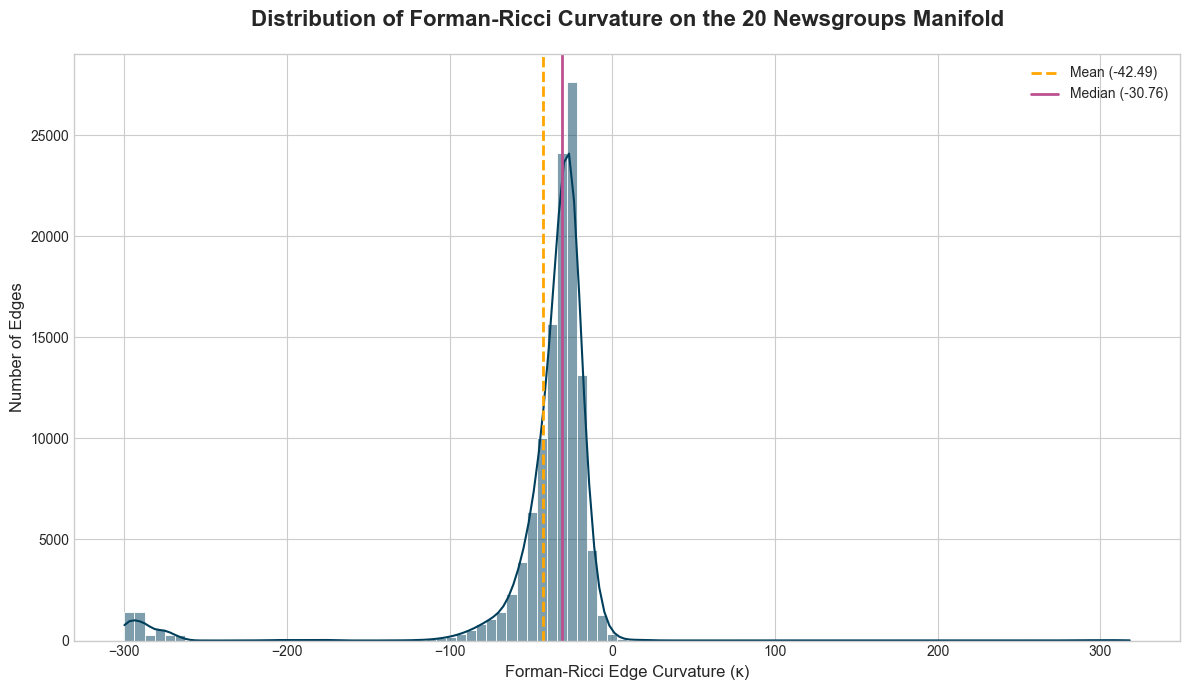

In [8]:
# In the final cell
# --- 4. Visualize the Curvature Distribution (The Deliverable) ---

print("\nStep 4: Generating the publication-quality histogram...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Create the histogram
sns.histplot(all_curvatures, bins=100, kde=True, ax=ax, color='#003f5c')

# Add vertical lines for mean and median to show the distribution's skew
mean_val = all_curvatures.mean()
median_val = np.median(all_curvatures)
ax.axvline(mean_val, color='#ffa600', linestyle='--', linewidth=2, label=f'Mean ({mean_val:.2f})')
ax.axvline(median_val, color='#bc5090', linestyle='-', linewidth=2, label=f'Median ({median_val:.2f})')

# Add titles and labels
ax.set_title(
    'Distribution of Forman-Ricci Curvature on the 20 Newsgroups Manifold',
    fontsize=16,
    fontweight='bold',
    pad=20
)
ax.set_xlabel('Forman-Ricci Edge Curvature (κ)', fontsize=12)
ax.set_ylabel('Number of Edges', fontsize=12)
ax.legend()

# Improve layout and save the figure
plt.tight_layout()
output_path = Path("../paper/figures/curvature_distribution.png")
output_path.parent.mkdir(exist_ok=True)
plt.savefig(output_path, dpi=300)

print(f"\nSUCCESS: Diagnostic plot saved to {output_path}")
plt.show()